In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from __future__ import division
import sys
import os
from os.path import join as pjoin
from glob import glob
sys.path.append('..')

In [99]:
import cv2
import csv
import numpy as np
from sklearn.model_selection import train_test_split
from utils.commands import unzip, mkdir, call, count_file, KaggleCLI, execute_in, unzip_all
from utils.plot import plot_images

cli = KaggleCLI('dogs-vs-cats-redux-kernels-edition')

In [32]:
data_path = pjoin(os.getcwd(), 'data')
model_path = pjoin(os.getcwd(), 'models')
result_path = pjoin(os.getcwd(), 'result')
sample_path = pjoin(data_path, 'sample')
train_name = 'train'
valid_name = 'valid'
test_name = 'ttest'

## Prepare Data for training

In [3]:
cli.download_data()

In [8]:
unzip_all(data_path)

In [37]:
categories = ['dog', 'cat']
for folder in [train_name, test_name, valid_name]:
    for ctg in categories:
        mkdir(pjoin(data_path, folder, ctg))
        mkdir(pjoin(sample_path, folder, ctg))

In [38]:
def move_data_to_category():
    call("mv cat.* cat")
    call('mv dog.* dog')

execute_in(pjoin(data_path, train_name), move_data_to_category)

In [39]:
def settle_data():
    train_cat, valid_cat, train_dog, valid_dog = train_test_split(os.listdir('train/cat'), os.listdir('train/dog'), test_size=0.2)
    valid_cat, test_cat, valid_dog, test_dog = train_test_split(valid_cat, valid_dog, test_size=0.4)
    
    strt = {
        train_name: {
            'dog': train_dog,
            'cat': train_cat,
        },
        valid_name: {
            'dog': valid_dog,
            'cat': valid_cat,
        },
        test_name: {
            'dog': test_dog,
            'cat': test_cat,
        }
    }
    
    for name, ds in strt.iteritems():
        if name == train_name:
            continue
        for ctg, data in ds.iteritems():
            for d in data:
                call('mv {} {}'.format(pjoin(train_name, ctg, d), pjoin(name, ctg)))
    
    for name, ds in strt.iteritems():
        for ctg, data in ds.iteritems():
            for d in data[:100]:
                call('cp {} {}'.format(pjoin(name, ctg, d), pjoin(sample_path, name, ctg)))
   

execute_in(data_path, settle_data)

## Fine tune VGG

In [81]:
work_path = data_path

In [82]:
from utils.pretrained_models import VGG16
from keras.preprocessing.image import ImageDataGenerator

In [83]:
vgg_model = VGG16.get_model(2).model

In [84]:
batch_size=32

train_datagen = ImageDataGenerator()
valid_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()
train_flow = train_datagen.flow_from_directory(
        pjoin(work_path, train_name),
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical')
valid_flow = valid_datagen.flow_from_directory(
        pjoin(work_path, valid_name),
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)
test_flow = test_datagen.flow_from_directory(
        pjoin(work_path, test_name),
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

Found 20000 images belonging to 2 classes.
Found 3000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [85]:
for l in vgg_model.layers[:-1]:
    l.trainable = False

In [86]:
train_steps = train_flow.samples // batch_size
valid_steps = valid_flow.samples // batch_size
epochs = 3

vgg_model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
vgg_model.fit_generator(
        train_flow,
        steps_per_epoch=train_steps,
        epochs=epochs,
        validation_data=valid_flow,
        validation_steps=valid_steps)

Epoch 1/3
625/625 [==============================] - 115s 184ms/step - loss: 0.0833 - acc: 0.9766 - val_loss: 0.0849 - val_acc: 0.9778
Epoch 2/3
625/625 [==============================] - 118s 189ms/step - loss: 0.0542 - acc: 0.9853 - val_loss: 0.0907 - val_acc: 0.9781
Epoch 3/3
625/625 [==============================] - 117s 187ms/step - loss: 0.0436 - acc: 0.9874 - val_loss: 0.0921 - val_acc: 0.9778


In [87]:
vgg_model.evaluate_generator(test_flow)

[0.09418331747721186, 0.9815]

In [88]:
preds = vgg_model.predict_generator(test_flow)

## Analyze result 

In [94]:
print test_flow.class_indices
print test_flow.classes[:5]
print preds[:5]
print test_flow.filenames[:5]

{'dog': 1, 'cat': 0}
[0 0 0 0 0]
[[1.00000000e+00 1.34374205e-14]
 [9.97073650e-01 2.92631006e-03]
 [1.00000000e+00 4.12421399e-12]
 [1.00000000e+00 2.04530555e-12]
 [1.00000000e+00 1.46321087e-17]]
['cat/cat.10012.jpg', 'cat/cat.10025.jpg', 'cat/cat.10031.jpg', 'cat/cat.10044.jpg', 'cat/cat.1005.jpg']


In [95]:
filenames = test_flow.filenames
expected_labels = test_flow.classes
predict_labels = np.round(1-preds[:, 0])

In [96]:
def plot_by_idx(idx, titles=None):
    plot_images([cv2.imread(pjoin(work_path, test_name, filenames[ix])) for ix in idx], columns=5, titles=titles)

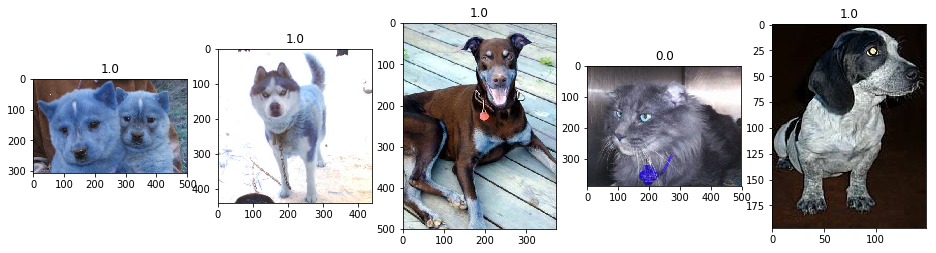

In [100]:
correct = np.where(predict_labels == expected_labels)[0]
image_ids = np.random.permutation(correct)[:5]
plot_by_idx(image_ids, predict_labels[image_ids])

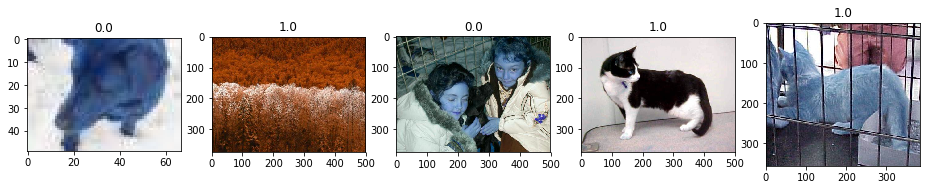

In [101]:
correct = np.where(predict_labels != expected_labels)[0]
image_ids = np.random.permutation(correct)[:5]
plot_by_idx(image_ids, predict_labels[image_ids])

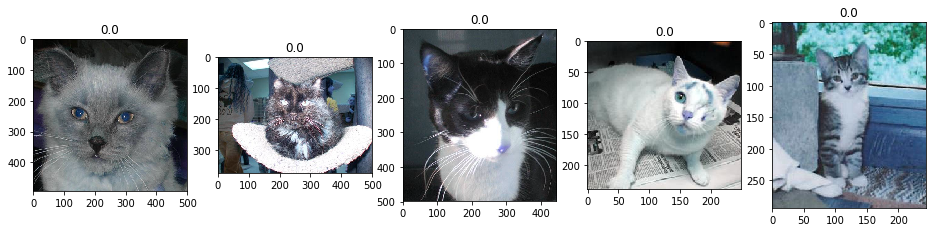

In [102]:
correct = np.where((predict_labels == expected_labels) & (predict_labels == 0))[0]
image_ids = np.random.permutation(correct)[:5]
plot_by_idx(image_ids, predict_labels[image_ids])

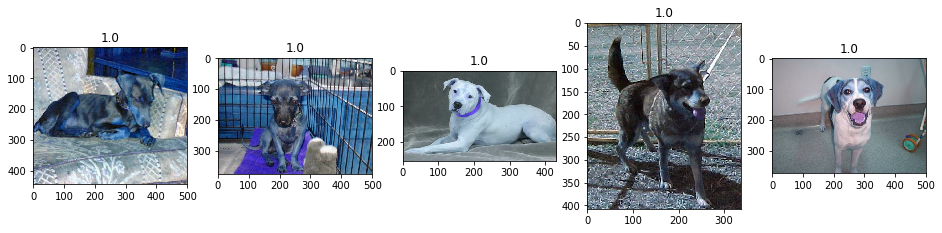

In [103]:
correct = np.where((predict_labels == expected_labels) & (predict_labels == 1))[0]
image_ids = np.random.permutation(correct)[:5]
plot_by_idx(image_ids, predict_labels[image_ids])

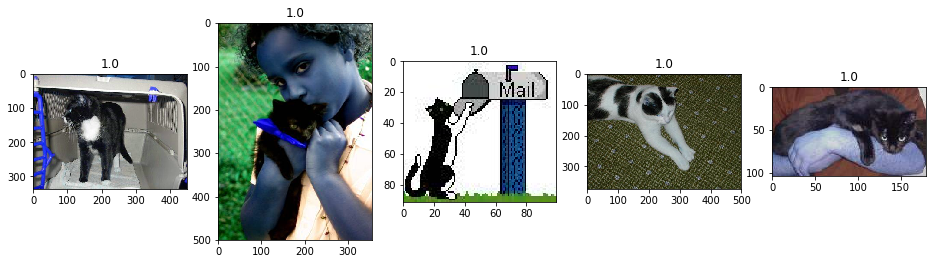

In [104]:
correct = np.where((predict_labels != expected_labels) & (predict_labels == 1))[0]
image_ids = np.random.permutation(correct)[:5]
plot_by_idx(image_ids, predict_labels[image_ids])

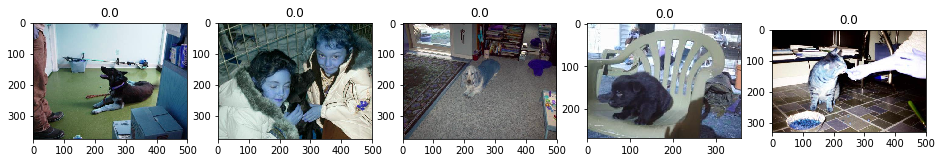

In [105]:
correct = np.where((predict_labels != expected_labels) & (predict_labels == 0))[0]
image_ids = np.random.permutation(correct)[:5]
plot_by_idx(image_ids, predict_labels[image_ids])

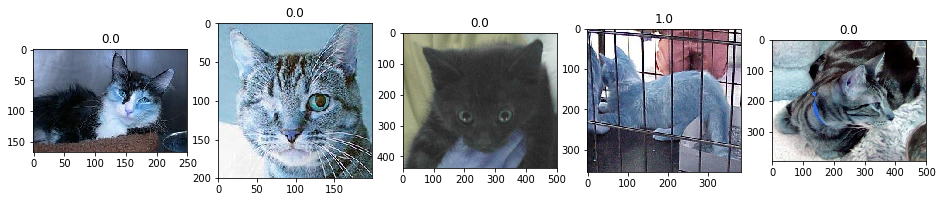

In [107]:
most_uncertain = np.argsort(np.abs(ours-0.5))
plot_by_idx(most_uncertain[:5], predict_labels[most_uncertain])

In [79]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [110]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(expected_labels, predict_labels)

Confusion matrix, without normalization
[[972  28]
 [  9 991]]


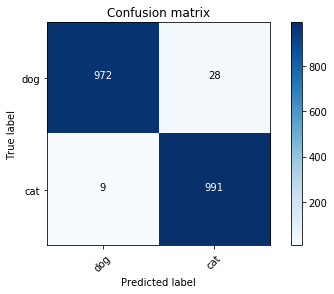

In [111]:
plot_confusion_matrix(cm, test_flow.class_indices)

## Generate submission file